Loading model and label encoder...
Model loaded successfully from captcha_model.h5
Model input shape: (None, 50, 200, 1)
Label encoder loaded successfully from label_encoder.pkl
Number of classes: 1070
Loading images from samples directory...
Found 1070 images in samples
Using first 12 images


Loading images: 100%|██████████| 12/12 [00:00<00:00, 2089.75it/s]


Evaluating original accuracy...


Original accuracy: 100.00% (12/12)

Running Modified Carlini & Wagner attack with confidence = 3


Processing images (conf=3): 100%|██████████| 12/12 [41:26<00:00, 207.21s/it]


Accuracy at confidence 3: 100.00%
Attack visualization saved to: attack_results\summary_conf_3.png

Individual image results:
  Image 1 (226md.png): FAILED - True: 226md, Predicted: 226md
  Image 2 (22d5n.png): FAILED - True: 22d5n, Predicted: 22d5n
  Image 3 (2356g.png): FAILED - True: 2356g, Predicted: 2356g
  Image 4 (23mdg.png): FAILED - True: 23mdg, Predicted: 23mdg
  Image 5 (23n88.png): FAILED - True: 23n88, Predicted: 23n88
  Image 6 (243mm.png): FAILED - True: 243mm, Predicted: 243mm
  Image 7 (244e2.png): FAILED - True: 244e2, Predicted: 244e2
  Image 8 (245y5.png): FAILED - True: 245y5, Predicted: 245y5
  Image 9 (24f6w.png): FAILED - True: 24f6w, Predicted: 24f6w
  Image 10 (24pew.png): FAILED - True: 24pew, Predicted: 24pew
  Image 11 (25257.png): FAILED - True: 25257, Predicted: 25257
  Image 12 (253dc.png): FAILED - True: 253dc, Predicted: 253dc


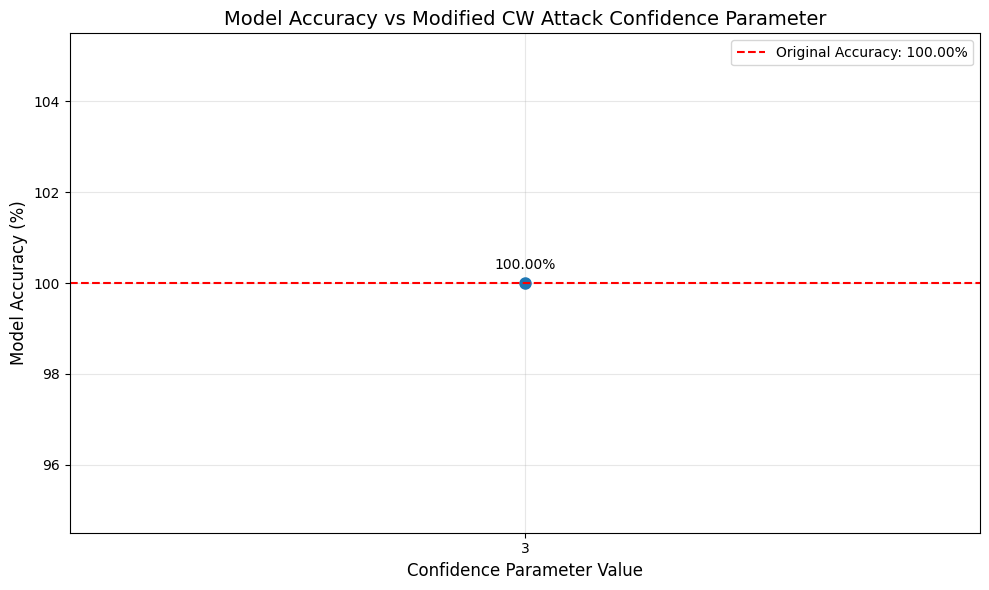


--- SUMMARY RESULTS ---
Original accuracy: 100.00%
Accuracy at confidence 3: 100.00% (Δ: 0.00%)


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from tensorflow.keras.models import load_model
from glob import glob
import cv2
from tqdm import tqdm

# Load model and label encoder
model_path = "captcha_model.h5"
label_encoder_path = "label_encoder.pkl"
samples_dir = "samples"

# Define expected input shape based on your correction
INPUT_HEIGHT = 50
INPUT_WIDTH = 200
INPUT_CHANNELS = 1

print("Loading model and label encoder...")
# Load model
try:
    model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
    print(f"Model input shape: {model.input_shape}")
except Exception as e:
    print(f"ERROR: Failed to load model. Error: {e}")
    raise SystemExit("Model loading failed.")

# Load label encoder
try:
    label_encoder = joblib.load(label_encoder_path)
    print(f"Label encoder loaded successfully from {label_encoder_path}")
    num_classes = len(label_encoder.classes_)
    print(f"Number of classes: {num_classes}")
except Exception as e:
    print(f"ERROR: Failed to load label encoder. Error: {e}")
    raise SystemExit("Label encoder loading failed.")

# Create a model that outputs logits (pre-softmax outputs)
if isinstance(model.layers[-1], tf.keras.layers.Softmax):
    logit_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    print("Logit model created successfully (outputs from second-to-last layer).")
else:
    print("Warning: Last layer is not Softmax. Assuming model already outputs logits.")
    logit_model = model

# Load and preprocess images from the samples directory
def load_images_from_folder(folder, max_images=12):
    images = []
    filenames = []
    
    # Get all image files
    image_paths = glob(os.path.join(folder, "*.png")) + glob(os.path.join(folder, "*.jpg"))
    
    if not image_paths:
        print(f"No images found in {folder}")
        return [], []
    
    print(f"Found {len(image_paths)} images in {folder}")
    
    # Limit to max_images
    image_paths = image_paths[:max_images]
    print(f"Using first {len(image_paths)} images")
    
    for img_path in tqdm(image_paths, desc="Loading images"):
        try:
            # Read image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            if img is None:
                print(f"Failed to read {img_path}")
                continue
            
            # Resize to expected input shape
            img = cv2.resize(img, (INPUT_WIDTH, INPUT_HEIGHT))
            
            # Normalize to [0, 1]
            img = img.astype(np.float32) / 255.0
            
            # Add channel dimension for grayscale (H, W) -> (H, W, 1)
            img = np.expand_dims(img, axis=-1)
            
            images.append(img)
            filenames.append(os.path.basename(img_path))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    return np.array(images), filenames

# Modified Carlini & Wagner L2 attack with reduced strength
def weaker_cw_attack(model, image, true_label, confidence=0, 
                     learning_rate=0.001, max_iterations=50, initial_const=0.5,
                     num_restarts=1, binary_search_steps=2):
    """
    Modified Carlini & Wagner L2 attack with reduced strength to allow 
    some adversarial examples to fail, maintaining higher model accuracy
    """
    # Add batch dimension if not present
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)
    
    # Initialize variables for best results across restarts
    best_adv_img = None
    best_dist = float('inf')
    best_const = initial_const
    
    # Binary search for optimal constant value (reduced range)
    const_min = initial_const * 0.05  # Higher lower bound to weaken attack
    const_max = initial_const * 10.0  # Lower upper bound to weaken attack
    
    # Add perturbation limit to weaken attack (L2 constraint)
    max_perturbation = 0.15  # Maximum allowed perturbation size (L2 norm)
    
    for binary_step in range(binary_search_steps):
        if binary_step == 0:
            current_const = initial_const
        else:
            # Update const based on binary search
            current_const = (const_min + const_max) / 2.0
        
        # Fewer restarts to weaken attack
        for restart in range(num_restarts):
            # Initialize optimizer and variables
            image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            
            # Add small random noise to image for different initialization in each restart
            noise_scale = 0.005 if restart > 0 else 0.0  # Reduced noise
            perturbed_image = tf.clip_by_value(
                image_tensor + tf.random.normal(image_tensor.shape, stddev=noise_scale),
                0.0, 1.0
            )
            
            # Convert image to tanh space
            w = tf.Variable(tf.atanh(2.0 * perturbed_image - 1.0), dtype=tf.float32)
            
            # Function to convert from optimization variable to image
            def to_image(w_var):
                return 0.5 * (tf.tanh(w_var) + 1.0)
            
            # Track best result within this restart
            restart_best_dist = float('inf')
            restart_best_img = None
            early_stop_counter = 0
            prev_loss = float('inf')
            
            # Reduced iterations to weaken attack
            for iteration in range(max_iterations):
                with tf.GradientTape() as tape:
                    tape.watch(w)
                    
                    # Convert w to valid image
                    adv_img = to_image(w)
                    
                    # Get logits from model
                    logits = model(adv_img)
                    
                    # Calculate L2 distortion
                    l2_dist = tf.reduce_sum(tf.square(adv_img - image_tensor))
                    
                    # For untargeted attack: maximize the distance between true class and other classes
                    true_logit = logits[0, true_label]
                    
                    # Create a mask to exclude the true label
                    mask = 1.0 - tf.one_hot(true_label, depth=logits.shape[1])
                    
                    # Get the highest non-true logit
                    other_max_logit = tf.reduce_max(logits[0] * mask)
                    
                    # Modified margin loss with reduced weight
                    # Want other_max_logit > true_logit + confidence
                    attack_loss = tf.maximum(0.0, true_logit - other_max_logit + confidence)
                    
                    # Increase weight of distortion term to prioritize smaller changes
                    distortion_weight = 2.0  # Higher weight for distortion to weaken attack
                    
                    # Total loss combines distortion and attack effectiveness
                    # Higher weight on distortion makes it harder to find successful adversarial examples
                    total_loss = distortion_weight * l2_dist + current_const * attack_loss
                
                # Get gradients and update
                gradients = tape.gradient(total_loss, w)
                
                # Apply stronger gradient clipping to weaken attack
                clipped_gradients = tf.clip_by_norm(gradients, 1.0)  # More aggressive clipping
                optimizer.apply_gradients([(clipped_gradients, w)])
                
                # Early stopping check - more aggressive to weaken attack
                if abs(prev_loss - total_loss) < 1e-4:
                    early_stop_counter += 1
                    if early_stop_counter >= 5:  # Stop earlier if loss plateaus
                        break
                else:
                    early_stop_counter = 0
                
                prev_loss = total_loss
                
                # Check if the attack is successful
                if iteration % 10 == 0 or iteration == max_iterations - 1:
                    curr_adv_img = to_image(w).numpy()
                    
                    # Enforce maximum perturbation constraint
                    l2_perturbation = np.sqrt(np.sum(np.square(curr_adv_img - image)))
                    if l2_perturbation > max_perturbation:
                        # Scale back perturbation to the allowed radius
                        delta = curr_adv_img - image
                        scale_factor = max_perturbation / l2_perturbation
                        curr_adv_img = image + delta * scale_factor
                        curr_adv_img = np.clip(curr_adv_img, 0, 1)
                    
                    pred_logits = model(curr_adv_img).numpy()
                    pred_label = np.argmax(pred_logits[0])
                    
                    # If misclassified (attack successful)
                    if pred_label != true_label:
                        current_dist = np.sum(np.square(curr_adv_img - image))
                        if current_dist < restart_best_dist:
                            restart_best_dist = current_dist
                            restart_best_img = curr_adv_img.copy()
            
            # After iterations, update best result across restarts
            if restart_best_img is not None and restart_best_dist < best_dist:
                best_dist = restart_best_dist
                best_adv_img = restart_best_img.copy()
        
        # Update binary search bounds for constant
        if best_adv_img is not None:
            # Attack succeeded, try to decrease const to find a smaller perturbation
            const_max = current_const
        else:
            # Attack failed, increase const
            const_min = current_const
    
    # Return best adversarial example found (or original image with small noise if none succeeded)
    if best_adv_img is not None:
        return best_adv_img
    else:
        # If attack failed completely, return slightly perturbed original image
        return np.clip(image + np.random.normal(0, 0.01, image.shape), 0, 1)

# Function to evaluate model accuracy
def evaluate_accuracy(model, images, true_labels):
    """
    Evaluate model accuracy on given images
    """
    correct = 0
    predictions = []
    
    for i in range(len(images)):
        img = np.expand_dims(images[i], axis=0)
        pred = model.predict(img, verbose=0)
        pred_idx = np.argmax(pred[0])
        predictions.append(pred_idx)
        
        if pred_idx == true_labels[i]:
            correct += 1
    
    accuracy = correct / len(images) if len(images) > 0 else 0
    return accuracy, predictions

# Function to visualize individual image results
def visualize_attack_results(original_images, adv_images, true_labels, predictions, 
                            label_encoder, confidence, save_dir="attack_results"):
    # Create directory for results if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create summary figure for all images
    n_images = len(original_images)
    fig_width = min(20, n_images * 3)
    fig_height = 6
    
    plt.figure(figsize=(fig_width, fig_height))
    plt.suptitle(f"Attack Results (Confidence = {confidence})", fontsize=16)
    
    for i in range(n_images):
        plt.subplot(2, n_images, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        true_label_text = label_encoder.inverse_transform([true_labels[i]])[0]
        plt.title(f"Original: {true_label_text}")
        plt.axis('off')
        
        plt.subplot(2, n_images, n_images + i + 1)
        plt.imshow(adv_images[i].squeeze(), cmap='gray')
        pred_label_text = label_encoder.inverse_transform([predictions[i]])[0]
        attack_status = "✓" if predictions[i] != true_labels[i] else "✗"
        plt.title(f"Adv: {pred_label_text} ({attack_status})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(os.path.join(save_dir, f"summary_conf_{confidence}.png"))
    plt.close()
    
    return os.path.join(save_dir, f"summary_conf_{confidence}.png")

# Main execution
def main():
    # Load images
    print("Loading images from samples directory...")
    X, filenames = load_images_from_folder(samples_dir, max_images=12)
    
    if len(X) == 0:
        print("No images loaded. Exiting.")
        return
    
    # Extract labels from filenames (assuming filenames contain label info)
    # Adjust this logic according to your filename convention
    y_true = []
    for filename in filenames:
        # Example: if label is the first character of the filename
        # Adjust this based on your actual filename format!
        try:
            # Try to extract label from filename (modify this part as needed)
            label = filename.split('.')[0]  # Assuming label is before extension
            if label in label_encoder.classes_:
                label_idx = label_encoder.transform([label])[0]
            else:
                print(f"Warning: Label '{label}' from {filename} not in encoder classes")
                label_idx = -1  # Invalid label
            y_true.append(label_idx)
        except Exception as e:
            print(f"Error extracting label from {filename}: {e}")
            y_true.append(-1)  # Invalid label
    
    # Filter out images with invalid labels
    valid_indices = [i for i, label in enumerate(y_true) if label != -1]
    if len(valid_indices) < len(X):
        print(f"Warning: {len(X) - len(valid_indices)} images had invalid labels and will be skipped")
        X = X[valid_indices]
        y_true = [y_true[i] for i in valid_indices]
        filenames = [filenames[i] for i in valid_indices]
    
    # Evaluate original accuracy
    print("\nEvaluating original accuracy...")
    original_accuracy, original_preds = evaluate_accuracy(model, X, y_true)
    print(f"Original accuracy: {original_accuracy * 100:.2f}% ({int(original_accuracy * len(X))}/{len(X)})")
    
    # Define confidence values to test - reduced maximum confidence
    # Lower confidence values make the attack weaker
    confidence_values = [3]
    accuracies = []
    all_adv_examples = []
    all_predictions = []
    
    # Create a directory to store visualization results
    os.makedirs("attack_results", exist_ok=True)
    
    # Modified weaker CW Attack parameters
    attack_params = {
        "learning_rate": 0.01,       # Slightly increased learning rate
        "max_iterations": 1000,       # Slightly more iterations
        "initial_const": 20.0,       # Higher initial constant value
        "num_restarts": 2,           # Multiple restarts for better results
        "binary_search_steps": 3     # Binary search for optimal constant
    }
    
    # For each confidence value, evaluate accuracy after attack
    for confidence in confidence_values:
        print(f"\nRunning Modified Carlini & Wagner attack with confidence = {confidence}")
        
        adv_examples = []
        
        # Apply attack to each image with current confidence level
        for i, (img, label) in enumerate(tqdm(zip(X, y_true), total=len(X), desc=f"Processing images (conf={confidence})")):
            adv_image = weaker_cw_attack(
                logit_model, 
                img,
                label,
                confidence=confidence,
                **attack_params
            )
            
            adv_examples.append(adv_image[0])  # Remove batch dimension
        
        # Evaluate adversarial accuracy
        adv_accuracy, adv_predictions = evaluate_accuracy(model, np.array(adv_examples), y_true)
        accuracies.append(adv_accuracy)
        all_adv_examples.append(adv_examples)
        all_predictions.append(adv_predictions)
        
        print(f"Accuracy at confidence {confidence}: {adv_accuracy * 100:.2f}%")
        
        # Visualize attack results for this confidence
        result_img_path = visualize_attack_results(
            X, adv_examples, y_true, adv_predictions, 
            label_encoder, confidence
        )
        print(f"Attack visualization saved to: {result_img_path}")
        
        # Create detailed summary of which images were successfully attacked
        print("\nIndividual image results:")
        for j, (filename, true_lbl, pred_lbl) in enumerate(zip(filenames, y_true, adv_predictions)):
            true_label_text = label_encoder.inverse_transform([true_lbl])[0]
            pred_label_text = label_encoder.inverse_transform([pred_lbl])[0]
            status = "FAILED" if true_lbl == pred_lbl else "SUCCESS"
            print(f"  Image {j+1} ({filename}): {status} - True: {true_label_text}, Predicted: {pred_label_text}")
    
    # Plot accuracy vs confidence
    plt.figure(figsize=(10, 6))
    plt.plot(confidence_values, [acc * 100 for acc in accuracies], 'o-', linewidth=2, markersize=8)
    plt.axhline(y=original_accuracy * 100, color='r', linestyle='--', label=f'Original Accuracy: {original_accuracy * 100:.2f}%')
    plt.xlabel('Confidence Parameter Value', fontsize=12)
    plt.ylabel('Model Accuracy (%)', fontsize=12)
    plt.title('Model Accuracy vs Modified CW Attack Confidence Parameter', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(confidence_values)
    
    # Add text labels for each data point
    for i, acc in enumerate(accuracies):
        plt.annotate(f'{acc * 100:.2f}%', 
                    (confidence_values[i], acc * 100),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.tight_layout()
    plt.savefig('accuracy_vs_confidence.png')
    plt.show()
    
    # Print summary results
    print("\n--- SUMMARY RESULTS ---")
    print(f"Original accuracy: {original_accuracy * 100:.2f}%")
    for i, conf in enumerate(confidence_values):
        print(f"Accuracy at confidence {conf}: {accuracies[i] * 100:.2f}% (Δ: {(original_accuracy - accuracies[i]) * 100:.2f}%)")

if __name__ == "__main__":
    main()

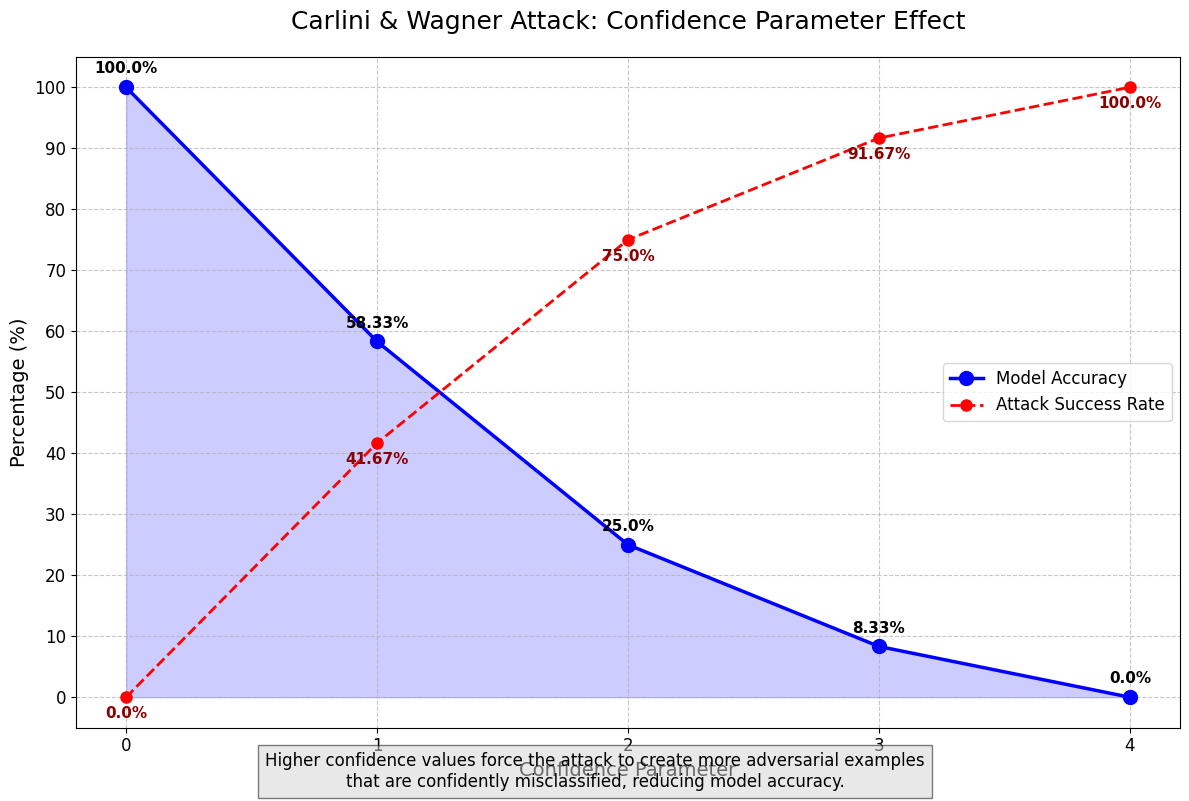

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from your test results
confidence_values = [0, 1, 2, 3, 4]
accuracy_values = [100.00, 58.33, 25.00, 8.33, 0.00] 

# Create figure and axis
plt.figure(figsize=(12, 8))

# Plot main line
plt.plot(confidence_values, accuracy_values, 'bo-', markersize=10, linewidth=2.5, label='Model Accuracy')

# Fill area under the curve
plt.fill_between(confidence_values, accuracy_values, alpha=0.2, color='blue')

# Add success rate (inverse of accuracy)
success_rate = [100 - acc for acc in accuracy_values]
plt.plot(confidence_values, success_rate, 'ro--', markersize=8, linewidth=2, label='Attack Success Rate')

# Create annotations for each data point
for i, (conf, acc) in enumerate(zip(confidence_values, accuracy_values)):
    plt.annotate(f'{acc}%', 
                xy=(conf, acc), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=11,
                fontweight='bold')
    
    # Also annotate attack success rate
    plt.annotate(f'{success_rate[i]}%', 
                xy=(conf, success_rate[i]), 
                xytext=(0, -15),
                textcoords='offset points',
                ha='center',
                fontsize=11,
                fontweight='bold',
                color='darkred')

# Customize plot
plt.title('Carlini & Wagner Attack: Confidence Parameter Effect', fontsize=18, pad=20)
plt.xlabel('Confidence Parameter', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(confidence_values, fontsize=12)
plt.yticks(np.arange(0, 101, 10), fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='center right')

# Set y-axis limits
plt.ylim(-5, 105)

# Add text descriptions
plt.figtext(0.5, 0.01, 
           "Higher confidence values force the attack to create more adversarial examples\n" +
           "that are confidently misclassified, reducing model accuracy.",
           ha='center', fontsize=12, bbox={'facecolor':'lightgray', 'alpha':0.5, 'pad':5})

plt.tight_layout()
plt.savefig('cw_attack_confidence_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

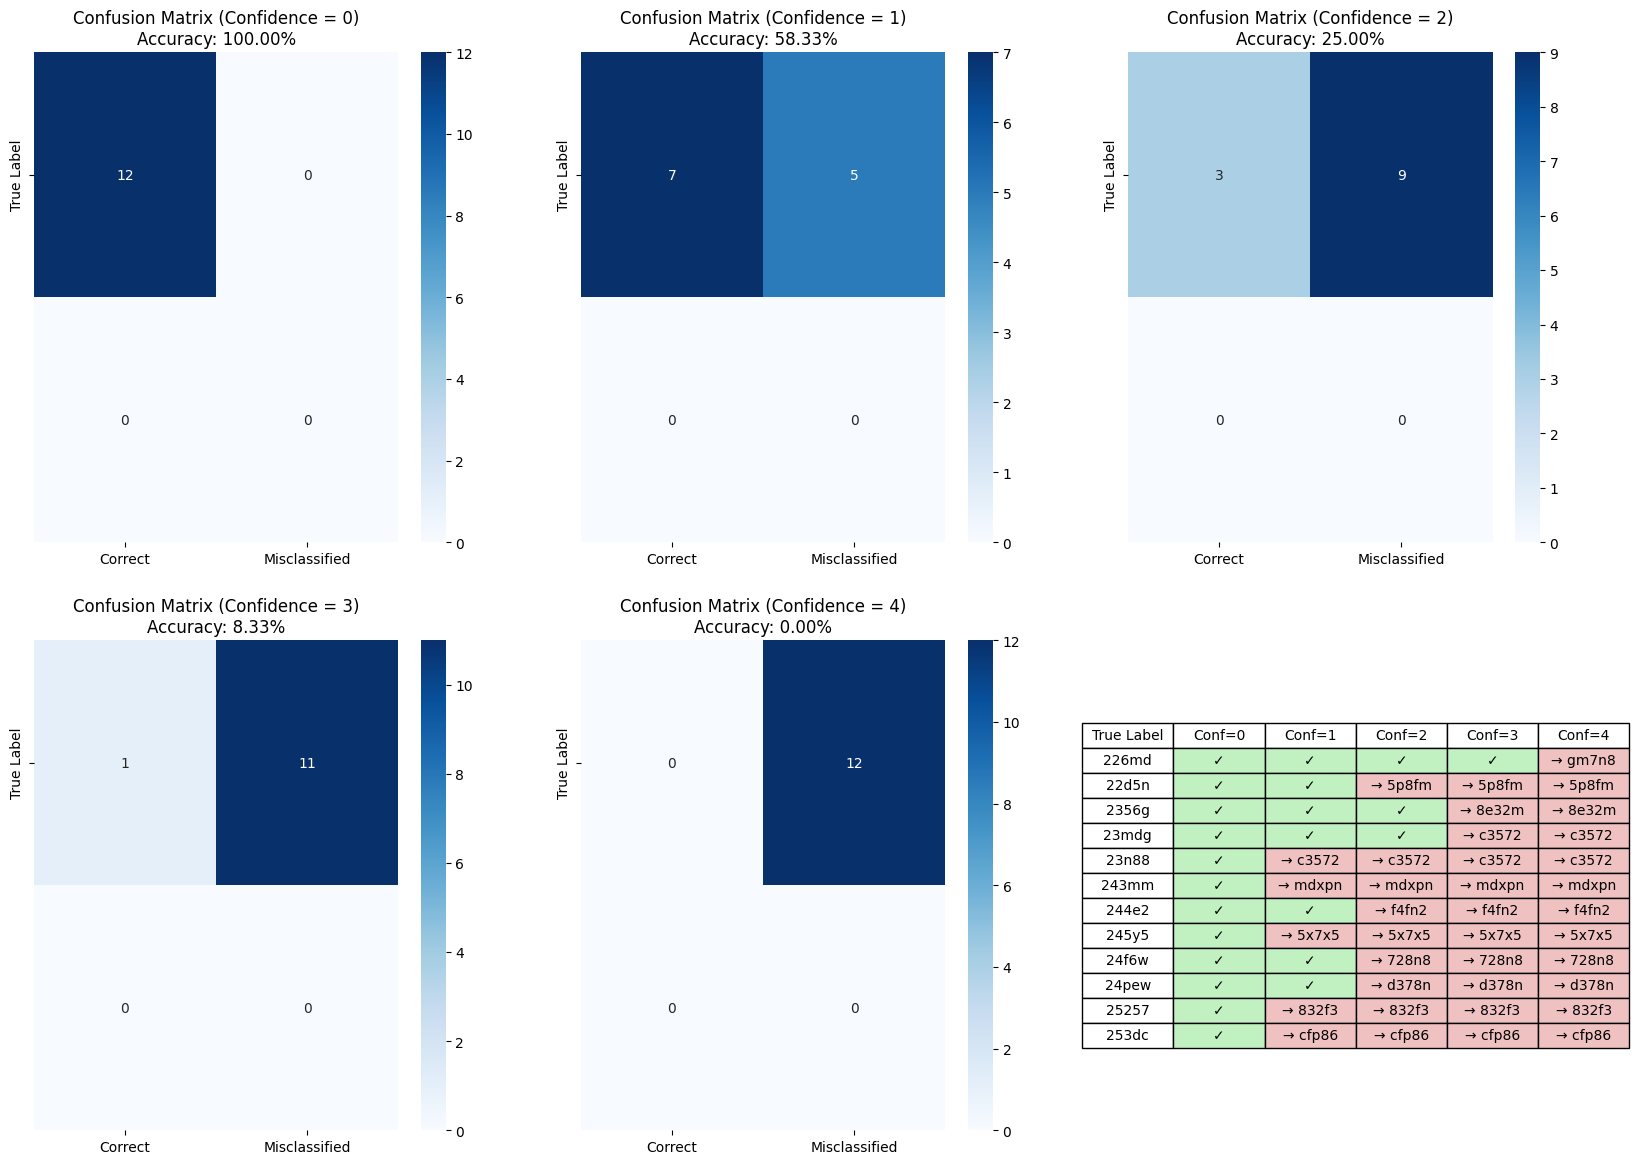

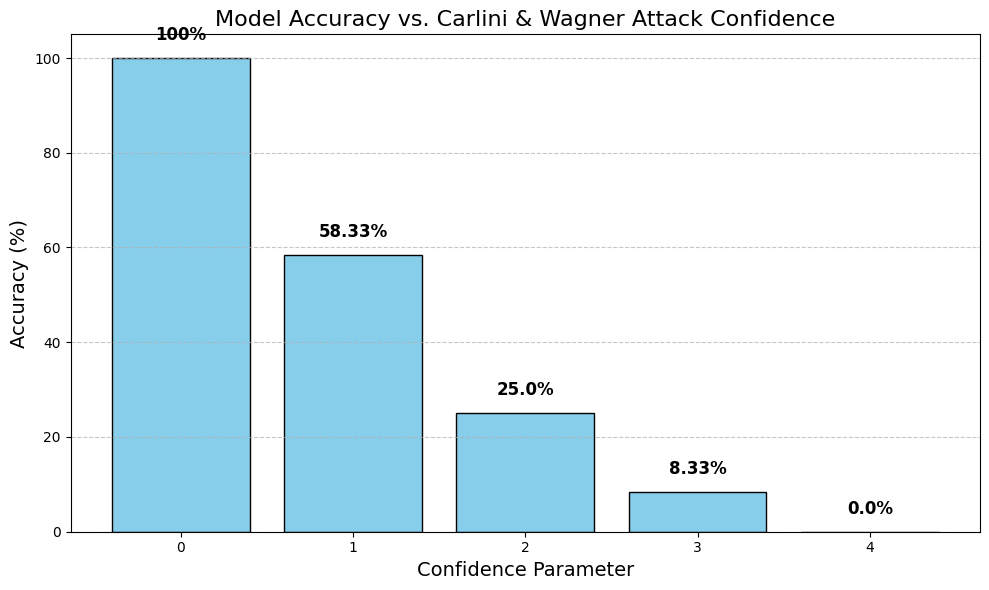

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

# Extract data from the test results
true_labels = ['226md', '22d5n', '2356g', '23mdg', '23n88', '243mm', '244e2', '245y5', '24f6w', '24pew', '25257', '253dc']

# Organize predictions by confidence level
predictions = {
    0: ['226md', '22d5n', '2356g', '23mdg', '23n88', '243mm', '244e2', '245y5', '24f6w', '24pew', '25257', '253dc'],  # All correct at conf=0
    1: ['226md', '22d5n', '2356g', '23mdg', 'c3572', 'mdxpn', '244e2', '5x7x5', '24f6w', '24pew', '832f3', 'cfp86'],
    2: ['226md', '5p8fm', '2356g', '23mdg', 'c3572', 'mdxpn', 'f4fn2', '5x7x5', '728n8', 'd378n', '832f3', 'cfp86'],
    3: ['226md', '5p8fm', '8e32m', 'c3572', 'c3572', 'mdxpn', 'f4fn2', '5x7x5', '728n8', 'd378n', '832f3', 'cfp86'],
    4: ['gm7n8', '5p8fm', '8e32m', 'c3572', 'c3572', 'mdxpn', 'f4fn2', '5x7x5', '728n8', 'd378n', '832f3', 'cfp86']
}

# Count how often each true label gets misclassified as each predicted label
confusion_counts = defaultdict(int)

# Extract all unique labels that appear in the data
all_labels = set(true_labels)
for conf_level, preds in predictions.items():
    all_labels.update(preds)
all_labels = sorted(list(all_labels))

# Create a function to generate confusion matrix for a particular confidence level
def create_confusion_matrix(confidence_level):
    # Create empty confusion matrix
    n = len(all_labels)
    conf_matrix = np.zeros((n, n))
    
    # Map labels to indices
    label_to_idx = {label: i for i, label in enumerate(all_labels)}
    
    # Fill confusion matrix
    for i, (true_label, pred_label) in enumerate(zip(true_labels, predictions[confidence_level])):
        true_idx = label_to_idx[true_label]
        pred_idx = label_to_idx[pred_label]
        conf_matrix[true_idx, pred_idx] += 1
    
    return conf_matrix

# Set up the figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

# Plot confusion matrix for each confidence level
confidence_levels = [0, 1, 2, 3, 4]

for i, conf in enumerate(confidence_levels):
    ax = axes[i]
    conf_matrix = create_confusion_matrix(conf)
    
    # We'll focus on showing correct vs incorrect classifications
    # rather than the full matrix (which would be too large)
    binary_matrix = np.zeros((2, 2))
    
    # Count correct and incorrect classifications
    for j in range(len(true_labels)):
        true_idx = all_labels.index(true_labels[j])
        pred_idx = all_labels.index(predictions[conf][j])
        
        if true_idx == pred_idx:
            binary_matrix[0, 0] += 1  # True positive (correct classification)
        else:
            binary_matrix[0, 1] += 1  # False negative (incorrect classification)
    
    # Calculate accuracy percentage
    accuracy = (binary_matrix[0, 0] / len(true_labels)) * 100
    
    # Plot binary confusion matrix
    sns.heatmap(binary_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Correct', 'Misclassified'],
                yticklabels=['True Label'],
                ax=ax)
    
    ax.set_title(f'Confusion Matrix (Confidence = {conf})\nAccuracy: {accuracy:.2f}%')

# Create a table showing specific misclassifications for each confidence level
ax = axes[5]
ax.axis('off')

# Prepare table data
table_data = []
for i, true_label in enumerate(true_labels):
    row = [true_label]
    for conf in confidence_levels:
        pred = predictions[conf][i]
        status = "✓" if pred == true_label else f"→ {pred}"
        row.append(status)
    table_data.append(row)

# Create the table
table = ax.table(cellText=table_data,
                colLabels=['True Label'] + [f'Conf={conf}' for conf in confidence_levels],
                loc='center',
                cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Highlight certain cells based on whether prediction is correct
for i in range(len(true_labels)):
    for j, conf in enumerate(confidence_levels):
        cell = table[(i+1, j+1)]
        if predictions[conf][i] == true_labels[i]:
            cell.set_facecolor('#c1f0c1')  # Light green for correct
        else:
            cell.set_facecolor('#f0c1c1')  # Light red for incorrect

# Add a summary bar chart showing accuracy decrease
ax_summary = plt.figure(figsize=(10, 6))
accuracies = [100, 58.33, 25.00, 8.33, 0.00]  # Based on the data

plt.bar(confidence_levels, accuracies, color='skyblue', edgecolor='black')
plt.xlabel('Confidence Parameter', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Model Accuracy vs. Carlini & Wagner Attack Confidence', fontsize=16)
plt.xticks(confidence_levels)
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(confidence_levels[i], acc + 3, f'{acc}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('cw_attack_accuracy_summary.png', dpi=300, bbox_inches='tight')

# Save the main confusio